### 0. Importation des modules 

In [250]:
import pandas as pd
import numpy as np
import prince 
import datetime as dt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns

## I. Importation des données et création des nouvelles variables d'intérêts.

In [3]:
# Importation de la base et visualisation des données 
df = pd.read_csv("C:\\Users\\youns\\Documents\\GitHub\\Statapp_Ornikar_ENSAE_2022-2023\\series_progress_sampled.csv")

C:\Users\youns\AppData\Local\Temp\ipykernel_8576\3482959876.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:\\Users\\youns\\Documents\\GitHub\\Statapp_Ornikar_ENSAE_2022-2023\\series_progress_sampled.csv")


#### I.1. Création d'une variable de score qualitatif avec 4 modalités, on pourra changer plus tard le nombre de modalités pour voir si cela induit une meilleure conservation de l'information

On regarde la distribution du score en pourcentage pour voir très grossièrement combien de modalités sont nécessaires pour discrétiser la variable

0.7667634500822779

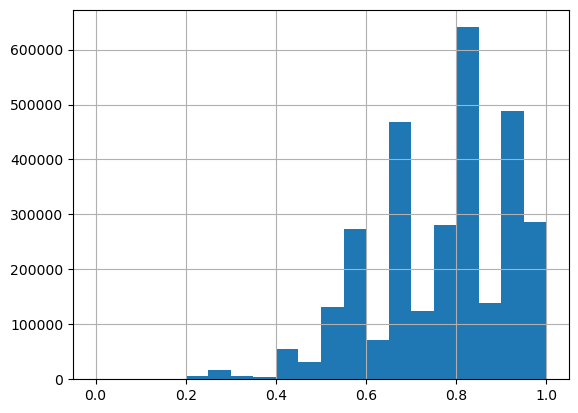

In [4]:
# disctribution des score en pourcentage
df["score_pct"].hist(bins=20)
df["score_pct"].mean()

In [5]:
# Création d'une nouvelle variable qui qualifie le score : score_pct_qual
tm = pd.Interval(-1,0.5,closed='right')
m = pd.Interval(0.5,0.7,closed='right')
bon = pd.Interval(0.7,0.9,closed='right')
tbon = pd.Interval(0.9,1.0 ,closed='right')

df["score_pct_qual"] = df["score_pct"].map({tm:"tres_mauvais",
                                           m:"mauvais",
                                           bon : "bon",
                                           tbon:"tres_bon"},
                                            na_action = None)
df.head(5)
df["score_pct_qual"].value_counts().sum()

3028067

#### I.2. Création d'une variable qui détermine le rang de la série faite par chaque learner, si cette variable vaut 3 alors cette série est la 3ème faite par le learner

In [6]:
# Création de df2, trié pour créer une nouvelle variable n_th_serie, qui vaut n si cette série est la n-ième série du learner:
df2 = df.sort_values('creation_serie')
df2.reset_index(drop = True,inplace = True)
df2['n_th_series'] = df2.groupby('learner_id').cumcount()

In [7]:

df2["nb_series"] = df2.groupby("learner_id")["learner_id"].transform("count")

In [36]:

df2['creation_serie_clean']= pd.to_datetime(df2['creation_serie'], format=('%Y-%m-%dT%H:%M:%S.%f'))

In [44]:
df2["time_difference"] = df2.groupby("learner_id")["creation_serie_clean"].diff()
df2["time_difference"] = [ e.total_seconds() for e in df2["time_difference"]] #Slow, should change it when we come with a better solution


In [67]:
df2["time_difference"].fillna(0)

0               NaN
1               NaN
2             430.0
3             334.0
4             435.0
             ...   
4342708    215798.0
4342709     71067.0
4342710       399.0
4342711       135.0
4342712       784.0
Name: time_difference, Length: 4342713, dtype: float64

In [97]:
df2["time_since_beginning"] = df2.groupby("learner_id")["creation_serie_clean"].apply(lambda x: x - x.iloc[0])
df2["time_since_beginning"] = [ e.total_seconds() for e in df2["time_since_beginning"]]

In [148]:
time_spent = df2.groupby("learner_id")["time_difference"].max()

# Add a new column to the DataFrame with the maximum time difference for each learner_id
df2["total_time_spent"] = df2["learner_id"].map(time_spent)

In [90]:
# Add a new column with the hour of the date
df2["hour"] = df2["creation_serie_clean"].apply(lambda x: x.hour)

# Add a new column indicating whether the date is between 10PM and 6AM
df2["night_or_day"] = df2["hour"].apply(lambda x: "N" if 22 <= x <= 23 or 0 <= x <= 5 else "D")


df2["month"] = df2["creation_serie_clean"].apply(lambda x: x.month)


df2.drop(['hour'], axis=1)

,learner_id,unique_learner_id,creation_serie,score,series_id,status,type,is_freemium,score_pct,training_session_id,...,score_pct_qual,n_th_series,nb_series,creation_serie_clean,time_difference,time_spent,time_since_beginning,night_or_day,month,season
0,9045,751634657445133149,2016-04-11T14:53:42.000Z,36.0,70,complete,training,0,0.900,c8f3b678-54c8-4ffc-97f4-96cb078bfd1d,...,bon,0,46,2016-04-11 14:53:42+00:00,NaN,NaT,0.0,D,4,Spring
1,5623,3466993288107043352,2016-04-11T20:35:09.000Z,29.0,70,complete,training,0,0.725,412ee334-7819-41b2-8db3-1925c8293ab3,...,bon,0,24,2016-04-11 20:35:09+00:00,NaN,NaT,0.0,D,4,Spring
2,5623,3466993288107043352,2016-04-11T20:42:19.000Z,29.0,71,complete,training,0,0.725,6fcf47d8-d25a-4a14-9c62-186d5bdec4c2,...,bon,1,24,2016-04-11 20:42:19+00:00,430.0,NaT,430.0,D,4,Spring
3,5623,3466993288107043352,2016-04-11T20:47:53.000Z,27.0,72,complete,exam,0,0.675,1a8bfd38-5b96-40a5-9dbe-fffa85b2fd1f,...,mauvais,2,24,2016-04-11 20:47:53+00:00,334.0,NaT,764.0,D,4,Spring
4,5623,3466993288107043352,2016-04-11T20:55:08.000Z,30.0,73,complete,training,0,0.750,3d61a0f6-710f-4e1c-84b9-a3afe09a7ffe,...,bon,3,24,2016-04-11 20:55:08+00:00,435.0,NaT,1199.0,D,4,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342708,2471785,5854087825286581620,2022-11-02T14:50:16.000Z,NaN,29089,incomplete,training,0,NaN,43b7a61d-cbfa-4c66-a387-684ea25fce49,...,NaN,29,30,2022-11-02 14:50:16+00:00,215798.0,NaT,10453393.0,D,11,Fall
4342709,831433,3067688422935602639,2022-11-02T14:50:18.000Z,NaN,29029,incomplete,exam,0,NaN,6c94c904-fe5a-43d3-b568-8449e57aec05,...,NaN,49,50,2022-11-02 14:50:18+00:00,71067.0,NaT,108836104.0,D,11,Fall
4342710,2596823,3849802320178053288,2022-11-02T14:50:44.000Z,NaN,29175,incomplete,theme,0,NaN,84917013-0e14-45a6-ab04-af4f102a1464,...,NaN,43,44,2022-11-02 14:50:44+00:00,399.0,NaT,485025.0,D,11,Fall
4342711,2724959,7326281107700376279,2022-11-02T14:50:54.000Z,10.0,29316,complete,theme,0,1.000,0d128b33-9cfa-48ea-bed0-14b488552755,...,tres_bon,616,617,2022-11-02 14:50:54+00:00,135.0,NaT,10804952.0,D,11,Fall


In [154]:
proportion = df2.groupby("learner_id").apply(lambda x: len(x[x["night_or_day"] == "N"]) / len(x))
df2["proportion_night"] = df2["learner_id"].map(proportion)

In [156]:
proportion

learner_id
77         0.000000
89         0.082418
223        1.000000
268        0.000000
429        1.000000
             ...   
2952360    0.000000
2952476    0.000000
2952553    0.000000
2952608    0.000000
2952699    0.000000
Length: 39777, dtype: float64

In [155]:
df2.head()

,learner_id,unique_learner_id,creation_serie,score,series_id,status,type,is_freemium,score_pct,training_session_id,...,creation_serie_clean,time_difference,time_spent,time_since_beginning,hour,night_or_day,month,season,total_time_spent,proportion_night
0,9045,751634657445133149,2016-04-11T14:53:42.000Z,36.0,70,complete,training,0,0.900,c8f3b678-54c8-4ffc-97f4-96cb078bfd1d,...,2016-04-11 14:53:42+00:00,NaN,55212473.0,0.0,14,D,4,Spring,55212473.0,0.043478
1,5623,3466993288107043352,2016-04-11T20:35:09.000Z,29.0,70,complete,training,0,0.725,412ee334-7819-41b2-8db3-1925c8293ab3,...,2016-04-11 20:35:09+00:00,NaN,933128.0,0.0,20,D,4,Spring,933128.0,0.000000
2,5623,3466993288107043352,2016-04-11T20:42:19.000Z,29.0,71,complete,training,0,0.725,6fcf47d8-d25a-4a14-9c62-186d5bdec4c2,...,2016-04-11 20:42:19+00:00,430.0,933128.0,430.0,20,D,4,Spring,933128.0,0.000000
3,5623,3466993288107043352,2016-04-11T20:47:53.000Z,27.0,72,complete,exam,0,0.675,1a8bfd38-5b96-40a5-9dbe-fffa85b2fd1f,...,2016-04-11 20:47:53+00:00,334.0,933128.0,764.0,20,D,4,Spring,933128.0,0.000000
4,5623,3466993288107043352,2016-04-11T20:55:08.000Z,30.0,73,complete,training,0,0.750,3d61a0f6-710f-4e1c-84b9-a3afe09a7ffe,...,2016-04-11 20:55:08+00:00,435.0,933128.0,1199.0,20,D,4,Spring,933128.0,0.000000


## II. Réalisation de la première réduction de dimension sur les variables qualitatives - ACM

In [ ]:
#!pip install prince --user

In [157]:
# Création d'une nouvelle variable qualitative pour "is_before_theory_exam_success_qual" qui était précédemment des booléens
df["is_before_theory_exam_success_qual"] = df["is_before_theory_exam_success"].map({True:"T",
                                                                              False:"F"},
                                                                             na_action = None)
df2["is_before_theory_exam_success_qual"] = df2["is_before_theory_exam_success"].map({True:"T",
                                                                              False:"F"},
                                                                             na_action = None)

In [158]:
# On remplace les Nan 
dfACM = df2.fillna('Autre')[["is_before_theory_exam_success_qual","type","status","course_name","is_freemium","night_or_day","month" ]]

In [159]:
#Réalisation de l'ACM
mca = prince.MCA()
mca = mca.fit(dfACM)

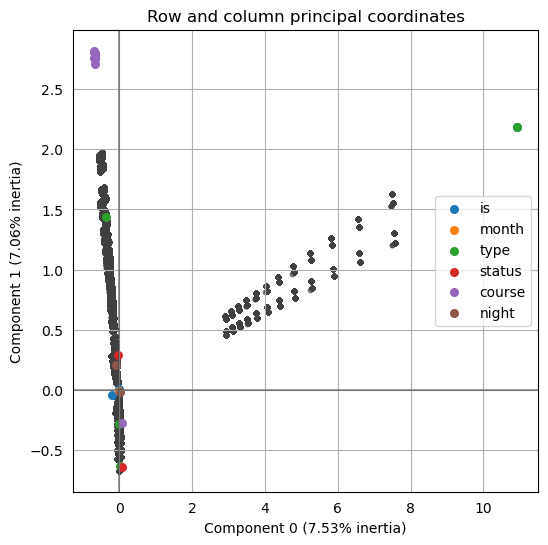

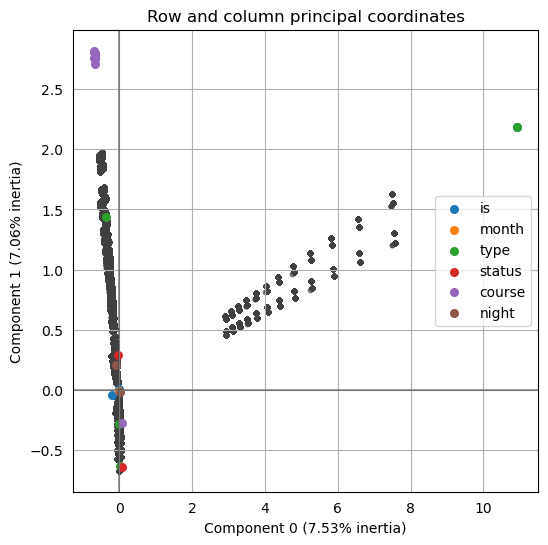

In [160]:
mca.explained_inertia_

ax = mca.plot_coordinates(
     X=dfACM,
     ax=None,
     figsize=(6, 6),
     show_row_points=True,
     row_points_size=10,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=30,
     show_column_labels=False,
     legend_n_cols=1
 )
ax.get_figure()

In [163]:
mca.explained_inertia_

[0.07525012709771087, 0.0706270471034026]

#### II.1. Récupération de deux composantes de l'ACM pour résumer l'information des variables qualitatives 

In [161]:
mca_transformed = mca.transform(dfACM)

In [242]:
#df_ACM_output = df[["learner_id", "unique_learner_id"]]
df_ACM_output = df2[["learner_id"]]
df_ACM_output[["score_ACM_1","score_ACM_2"]] = mca_transformed 
df_ACM_output[["time_since_beginning","score_pct","n_th_series","time_difference"]] = df2[["time_since_beginning","score_pct","n_th_series","time_difference"]]

C:\Users\youns\AppData\Local\Temp\ipykernel_8576\4038762203.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_output[["score_ACM_1","score_ACM_2"]] = mca_transformed
C:\Users\youns\AppData\Local\Temp\ipykernel_8576\4038762203.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ACM_output[["score_ACM_1","score_ACM_2"]] = mca_transformed
C:\Users\youns\AppData\Local\Temp\ipykernel_8576\4038762203.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

**On a maintenant un dataframe qui comporte 4 variables quantitatives par séries sur lequel on va réaliser une nouvelle réduction de dimension, cette fois ci une ACP. Cela nous permet d'afficher des cercles de corrélations pour mieux identifier quelles sont les variables réellement explicatives de la variance.**

In [243]:
df_ACM_output.head(5)

,learner_id,score_ACM_1,score_ACM_2,time_since_beginning,score_pct,n_th_series,time_difference
0,9045,0.004317,-0.182977,0.0,0.900,0,NaN
1,5623,0.004317,-0.182977,0.0,0.725,0,NaN
2,5623,0.004317,-0.182977,430.0,0.725,1,430.0
3,5623,-0.006311,-0.088143,764.0,0.675,2,334.0
4,5623,0.004317,-0.182977,1199.0,0.750,3,435.0


Pour l'instant nous avons rempli les valeurs Nan avec des 0 en attendant de trouver une solution plus convaincante. 

## III. Réalisation de l'ACP au niveau série

In [244]:
df_ACM_output_N = df_ACM_output.fillna(0)
# ACP sur les variables quantitatives 
df_ACM_output_Normalize = normalize(df_ACM_output_N)
pca_series = PCA()
pca_series.fit(df_ACM_output_Normalize)

PCA()

#### III.1 Conservation de la variance

In [246]:
eig = pd.DataFrame(
    {
        "Dimension" : ["n=" + str(x + 1) for x in range(7)], 
        "Variance expliquée" : pca_series.explained_variance_,
        "% variance expliquée" : np.round(pca_series.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca_series.explained_variance_ratio_) * 100)
    }
)
eig

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,n=1,1.600328e-01,94.0,94.0
1,n=2,6.394658e-03,4.0,98.0
2,n=3,4.082785e-03,2.0,100.0
3,n=4,1.255617e-09,0.0,100.0
4,n=5,6.843894e-11,0.0,100.0
5,n=6,2.294732e-12,0.0,100.0
6,n=7,2.900990e-13,0.0,100.0


In [283]:
np.random.normal()

-0.7412107778455703

La première composante de l'ACP conserve ici très bien l'information avec 72% de la variance expliquée. Nous allons donc tenter de lier cette composante à l'une des variables présente dans l'ACP.

#### III.2 Cercle de corrélation

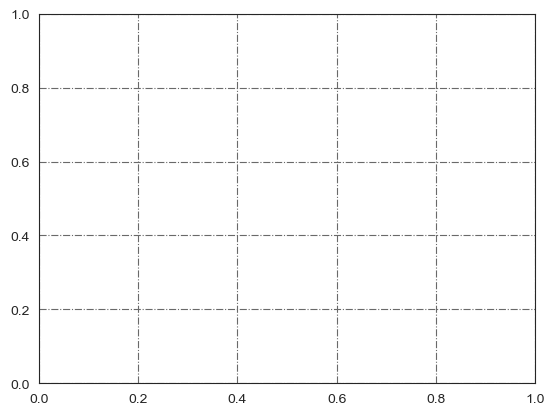

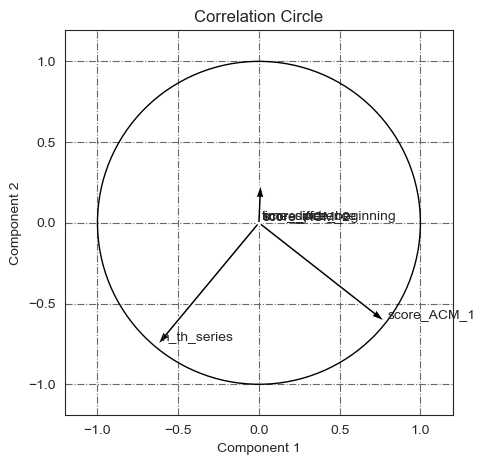

In [303]:
# Get the PCA components (loadings)
PCs = pca_series.components_

# Use quiver to generate the basic plot
fig = plt.figure(figsize=(5,5))
plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
           PCs[0,:], PCs[1,:], 
           angles='xy', scale_units='xy', scale=1, linewidth = 1)

# Add labels based on feature names (here just numbers)
feature_names = ["score_ACM_1","score_ACM_2","score_pct","n_th_series","time_difference","time_since_beginning"]

for i,j,z in zip(PCs[1,:]+0.02, PCs[0,:]+0.02, feature_names):
    plt.annotate(z, (j, i))

# Add unit circle
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='black',linewidth=1)
plt.gca().add_artist(circle)

# Ensure correct aspect ratio and axis limits
plt.axis('equal')
plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])

# Label axes
plt.title('Correlation Circle')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.rc('grid', linestyle="-.", color='dimgrey')
# Done
plt.show()

On voit ici que la première composante est bien représentée par le score_pct tandis que la 2ème composante est plutôt bien réprésentée par les score de l'ACM

#### III.2. Récupération des coordonnées de l'ACP au niveau séries et ajout de la colonne learner_id pour chaque séries 

In [201]:
coords = pca_series.fit_transform(df_ACM_output_Normalize)
df_pca_output = pd.DataFrame(coords)

In [202]:
df_pca_output[["learner_id"]]=df2[["learner_id"]]

In [204]:
df_pca_output.columns = ['Score_PCA_1_', 'Score_PCA_2_', 'Score_PCA_3_', 'Score_PCA_4_','Score_PCA_5_','Score_PCA_6_','Score_PCA_7_', 'learner_id']

In [205]:
df_pca_output

,Score_PCA_1_,Score_PCA_2_,Score_PCA_3_,Score_PCA_4_,Score_PCA_5_,Score_PCA_6_,Score_PCA_7_,learner_id
0,1.142480,0.195857,-0.074273,-0.000004,1.004993e-04,-1.711875e-06,9.116116e-06,9045
1,1.142480,0.195857,-0.074273,-0.000004,1.311035e-04,-3.440446e-06,1.796499e-05,5623
2,1.091073,0.160180,0.013355,0.000168,1.301780e-04,-3.357810e-06,1.790203e-05,5623
3,1.050391,0.115049,0.007107,0.000336,1.188131e-04,-1.537540e-06,2.225105e-06,5623
4,0.993578,0.072040,0.035481,0.000499,1.317200e-04,-3.082888e-06,1.718982e-05,5623
...,...,...,...,...,...,...,...,...
4342708,-0.067088,-0.063665,0.023005,-0.000026,-4.149363e-08,2.555364e-08,3.209951e-08,2471785
4342709,-0.257485,0.047136,-0.022298,-0.000009,-9.537466e-09,-1.690879e-08,-1.522538e-09,831433
4342710,1.014132,0.067670,-0.041205,-0.000005,-5.340279e-07,-1.975564e-07,-8.036784e-09,2596823
4342711,-0.053931,-0.074790,0.004932,0.000025,-4.642179e-09,3.526808e-08,-5.448579e-09,2724959


#### III.3. Conservation de la première composante conservant 72% de la variance

In [208]:
df_pca_output.drop(['Score_PCA_2_', 'Score_PCA_3_', 'Score_PCA_4_','Score_PCA_5_','Score_PCA_6_','Score_PCA_7_'], axis=1)


,Score_PCA_1_,learner_id
0,1.142480,9045
1,1.142480,5623
2,1.091073,5623
3,1.050391,5623
4,0.993578,5623
...,...,...
4342708,-0.067088,2471785
4342709,-0.257485,831433
4342710,1.014132,2596823
4342711,-0.053931,2724959


#### III.4 Réalisation d'un pivot avec la variable learner_id 

In [209]:
df_learner=pd.pivot_table(df_pca_output,index=['learner_id'],columns=df_ACM_output.groupby(['learner_id']).cumcount().add(1),values=['Score_PCA_1_'],aggfunc='sum')
df_learner.columns=df_learner.columns.map('{0[0]}{0[1]}'.format) 


Le tableau df_learner donne le score de la composante 1 de l'ACP par learner dans l'odre chronologique de leur séries. La colonne Score_PCA_1_1 donne donc la coordonnées suivant la première composante de l'ACP pour la première série effectuée par le learner.

In [210]:
df_learner.head(5)

,Score_PCA_1_1,Score_PCA_1_2,Score_PCA_1_3,Score_PCA_1_4,Score_PCA_1_5,Score_PCA_1_6,Score_PCA_1_7,Score_PCA_1_8,Score_PCA_1_9,Score_PCA_1_10,...,Score_PCA_1_13380,Score_PCA_1_13381,Score_PCA_1_13382,Score_PCA_1_13383,Score_PCA_1_13384,Score_PCA_1_13385,Score_PCA_1_13386,Score_PCA_1_13387,Score_PCA_1_13388,Score_PCA_1_13389
learner_id,,,,,,,,,,,,,,,,,,,,,
77,1.142420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,1.142436,-0.045026,-0.221850,-0.228592,-0.072652,-0.263439,-0.263351,-0.263458,-0.263306,-0.263353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223,1.142476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,1.142476,-0.016347,-0.089292,-0.082297,-0.160691,-0.263268,-0.263335,-0.263284,-0.263336,-0.259610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
429,1.142480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## IV. Restriction sur des learners avec un nombre raisonnable de séries

**Le problème qu'on rencontre ici est qu'un grand nombre de learners n'ont fait que très peu de séries. On va donc resteindre le data frame df_learner pour ne garder que les learners avec un nombre raisonnable de séries (encore à déterminer proprement).**

On peut voir ce problème sur la fonction de répartition du nombre de séries par learner plot ci dessous

[Text(0.5, 0, 'Nombre de séries'), Text(0, 0.5, 'Proportion')]

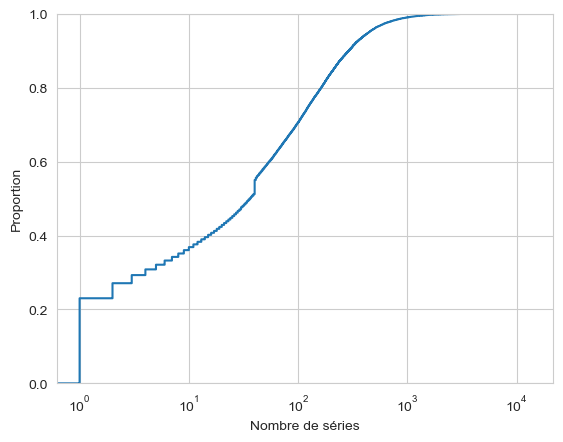

In [211]:
learner_count = df["learner_id"].value_counts()
sns.set_style("whitegrid")
plot = sns.ecdfplot(learner_count,log_scale = True )
plot.set(xlabel = "Nombre de séries", ylabel = "Proportion")

In [214]:
df_learner_cutted = df_learner.drop(df_learner.columns[[i for i in range(301,13389)]], axis=1) 


On a donc garder ici les learners avec plus de 50 séries et moins de 1000 séries, ces nombres sont totalement arbitraires pour le moment. Nous allons par la suite remplacé les valeurs Nan par 0 et intégré une variable "nombre de séries effectuée" au dataframe pour que l'ACP puissent prendre en compte ces valeurs manquantes qui portent beaucoup d'information.

In [218]:
df_learner_cutted[["proportion_night","nb_series","total_time_spent"]]=df2[["proportion_night","nb_series","total_time_spent"]]


In [229]:
score_avg=df2.groupby("learner_id")["score_pct"].mean()

In [236]:
df_learner_cutted["score_avg"]= df_learner_cutted.index.map(score_avg)

In [237]:
df_learner_cutted

,Score_PCA_1_1,Score_PCA_1_2,Score_PCA_1_3,Score_PCA_1_4,Score_PCA_1_5,Score_PCA_1_6,Score_PCA_1_7,Score_PCA_1_8,Score_PCA_1_9,Score_PCA_1_10,...,Score_PCA_1_296,Score_PCA_1_297,Score_PCA_1_298,Score_PCA_1_299,Score_PCA_1_300,Score_PCA_1_301,proportion_night,nb_series,total_time_spent,score_avg
learner_id,,,,,,,,,,,,,,,,,,,,,
77,1.142420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,42,105145145.0,0.950000
89,1.142436,-0.045026,-0.221850,-0.228592,-0.072652,-0.263439,-0.263351,-0.263458,-0.263306,-0.263353,...,NaN,NaN,NaN,NaN,NaN,NaN,0.033333,30,773233.0,0.777059
223,1.142476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.047619,21,19815055.0,0.725000
268,1.142476,-0.016347,-0.089292,-0.082297,-0.160691,-0.263268,-0.263335,-0.263284,-0.263336,-0.259610,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,30,1495468.0,0.812500
429,1.142480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.066667,30,28635645.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2952360,1.142480,1.142434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.096690,1148,2073528.0,0.600000
2952476,1.142480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.113360,247,13818664.0,0.600000
2952553,1.142480,1.142480,1.142328,1.142169,1.142031,1.141912,1.141778,1.141763,1.141761,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.061881,404,2748804.0,0.570833


## V. Deuxième ACP au niveau learner (sur les learner sélectionnés en IV)

In [238]:
df_learner_PCA_N = df_learner_cutted.fillna(0)
# ACP sur les variables quantitatives 
df_learner_PCA_Normalize = normalize(df_learner_PCA_N)
pca_learner = PCA()
pca_learner.fit(df_learner_PCA_Normalize)

PCA()

In [239]:
pca_learner.explained_variance_
eig = pd.DataFrame(
    {
        "Dimension" : ["n=" + str(x + 1) for x in range(len(df_learner_PCA_Normalize[0]))], 
        "Variance expliquée" : pca_learner .explained_variance_,
        "% variance expliquée" : np.round(pca_learner.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca_learner.explained_variance_ratio_) * 100)
    }
)
eig

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,n=1,2.832748e-03,76.0,76.0
1,n=2,3.162348e-04,9.0,85.0
2,n=3,2.271208e-04,6.0,91.0
3,n=4,1.153596e-04,3.0,94.0
4,n=5,4.867426e-05,1.0,95.0
...,...,...,...,...
300,n=301,3.465488e-19,0.0,100.0
301,n=302,3.202960e-19,0.0,100.0
302,n=303,3.015885e-19,0.0,100.0
303,n=304,2.765630e-19,0.0,100.0


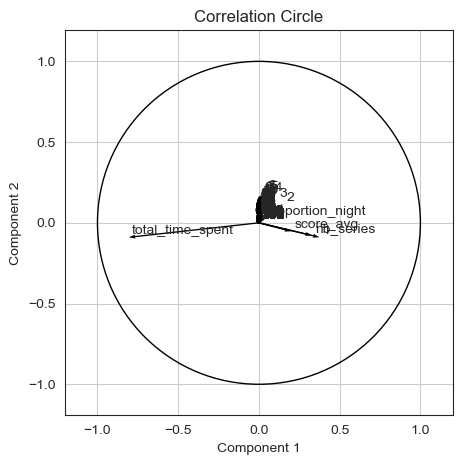

In [298]:
# Get the PCA components (loadings)
PCs = pca_learner.components_

# Use quiver to generate the basic plot
fig = plt.figure(figsize=(5,5))
plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
           PCs[0,:], PCs[1,:], 
           angles='xy', scale_units='xy', scale=1)

# Add labels based on feature names 
feature_names = [str(i+1) for i in range(len(df_learner_PCA_Normalize[0]))]
feature_names[-1]='score_avg'
feature_names[-2]='total_time_spent'
feature_names[-3]='nb_series'
feature_names[-4]='proportion_night'

for i,j,z in zip(PCs[1,:]+0.02, PCs[0,:]+0.02, feature_names):
    plt.annotate(z, (j, i))

# Add unit circle
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='black')
plt.gca().add_artist(circle)

# Ensure correct aspect ratio and axis limits
plt.axis('equal')
plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])

# Label axes
plt.title('Correlation Circle')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.rc('grid', linestyle="-", color='dimgrey')
# Done
sns.set_style("white")
plt.show()